# Fake Image Detection with ELA and CNN

![full-architecture](docs/model-architecture.jpg "Architecture")

In [ ]:
!pip install seaborn
!pip install keras
!pip install tensorflow
# !pip install numpy --upgrade


In [2]:
!python3.10 -m pip install --upgrade pip

'python3.10' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!pip install scikit-learn scipy matplotlib


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

# from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau, EarlyStopping

sns.set(style='white', context='notebook', palette='deep')

## Initial preparation

In [2]:
from PIL import Image
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance

#### Functions

In [3]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]

In [4]:
def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = filename.split('.')[0] + '.resaved.jpg'
    ELA_filename = filename.split('.')[0] + '.ela.png'
    
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality=quality)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    return ela_im

### Sample: Real Image

Let's open a real (not-fake) image as a sample.

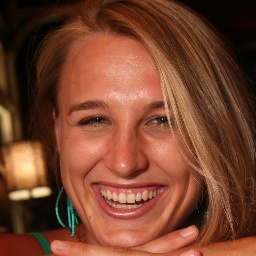

In [ ]:
Image.open('C:/Users/OneDrive/Desktop/DeepFake_DetectionAPP/Deep_Faking_Detection_App_PK/real1.jpg')

This is how it looks like after it is processed with error-level analysis (ELA).

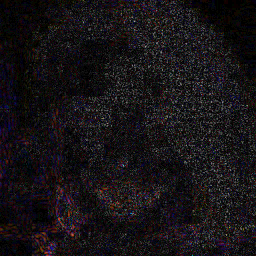

In [ ]:
convert_to_ela_image('C:/Users/OneDrive/Desktop/DeepFake_DetectionAPP/Deep_Faking_Detection_App_PK/real1.jpg', 90)

### Sample: Fake Image

This is how it looks like after it has been edited.

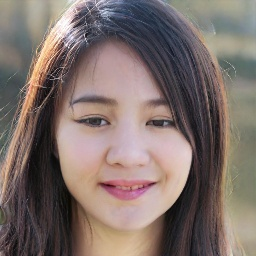

In [ ]:
Image.open('C:/Users/OneDrive/Desktop/DeepFake_DetectionAPP/Deep_Faking_Detection_App_PK/fake1.jpg')

This is the result of the fake image after getting through ELA. We can compare the difference between the picture below and the real picture's ELA result.

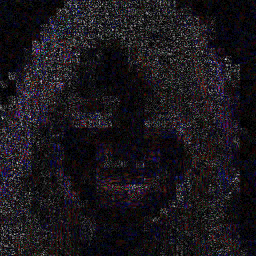

In [ ]:
convert_to_ela_image('C:/Users/OneDrive/Desktop/DeepFake_DetectionAPP/Deep_Faking_Detection_App_PK/fake1.jpg', 90)

With our own naked eyes, we are able to differ which is the ELA result of the real picture and which one is the result of fake image. By saying real here, what we mean is a non-CGI picture that is not fabricated/edited in any way, e.g. splicing.

## Data preparation

### Read dataset and conversion to ELA

In [ ]:
import os
import csv
from PIL import Image  # Use PIL for image processing

def create_image_dataset_csv(fake_folder, real_folder, output_csv):
    # Initialize an empty list to store image information
    image_data = []

    # Process fake images
    fake_files = os.listdir(fake_folder)
    for filename in fake_files:
        if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust based on your image formats
            file_path = os.path.join(fake_folder, filename)
            label = 0  # Assign label 0 for fake
            image_data.append((file_path, label))

    # Process real images
    real_files = os.listdir(real_folder)
    for filename in real_files:
        if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust based on your image formats
            file_path = os.path.join(real_folder, filename)
            label = 1  # Assign label 1 for real
            image_data.append((file_path, label))

    # Write image data to CSV file
    with open(output_csv, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['file_path', 'label'])  # Header row
        csv_writer.writerows(image_data)

    print(f"CSV file '{output_csv}' has been created successfully with {len(image_data)} entries.")

# Example usage:
fake_images_folder = 'C:/Users/OneDrive/Desktop/DeepFake_DetectionAPP/mixed_dataset/fake'
real_images_folder = 'C:/Users/OneDrive/Desktop/DeepFake_DetectionAPP/mixed_dataset/real'
output_csv_file = 'image_dataset.csv'

create_image_dataset_csv(fake_images_folder, real_images_folder, output_csv_file)


CSV file 'image_dataset.csv' has been created successfully with 948 entries.


In [10]:
import pandas as pd

In [11]:
# dataset = pd.read_csv('datasets/dataset.csv')
dataset = pd.read_csv('image_dataset.csv')

In [ ]:
dataset.head()

In [13]:
X = []
Y = []

In [14]:
X

[]

In [ ]:
for index, row in dataset.iterrows():
    X.append(array(convert_to_ela_image(row[0], 90).resize((128, 128))).flatten() / 255.0)
    Y.append(row[1])


# for index, row in dataset.iterrows():
#     # Assuming row[0] contains image file paths and row[1] contains labels
#     image_path = row['image_path']  # Adjust column name as per your DataFrame structure
#     label = row['label']  # Adjust column name as per your DataFrame structure
    
#     # Convert image to ELA and preprocess
#     ela_image = convert_to_ela_image(image_path, 90).resize((128, 128))
#     X.append(np.array(ela_image).flatten() / 255.0)  # Convert image to numpy array, flatten and normalize
#     Y.append(label)

### Normalization

In [16]:
X = np.array(X)
Y = to_categorical(Y, 2)

### Reshape X

In [17]:
X = X.reshape(-1, 128, 128, 3)

## Train-test split

In [18]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

## CNN building

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', input_shape = (128,128,3)))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu'))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 124, 124, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 120, 120, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      29,491,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,520,034 (112.61 MB)

 Trainable params: 29,520,034 (112.61 MB)

 Non-trainable params: 0 (0.00 B)

### Add optimizer

In [ ]:
optimizer = RMSprop(learning_rate=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)


In [22]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


### Define early stopping

In [23]:
early_stopping = EarlyStopping(monitor='val_acc',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='max')

### Model training

In [24]:
epochs = 10
batch_size = 100

In [ ]:
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_val, Y_val), verbose = 2, callbacks=[early_stopping])

## Performance measure

### Accuracy and loss curves during training-validation

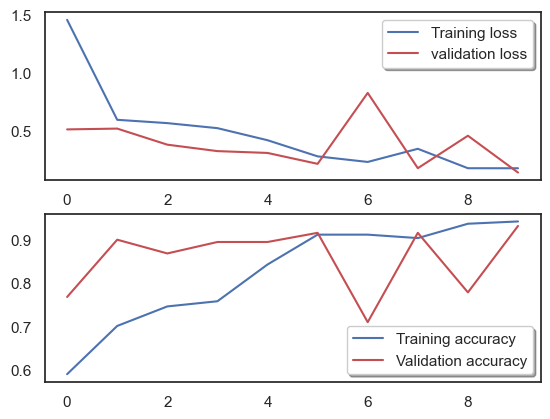

In [26]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Confusion matrix

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


<Axes: title={'center': 'Confusion Matrix'}>

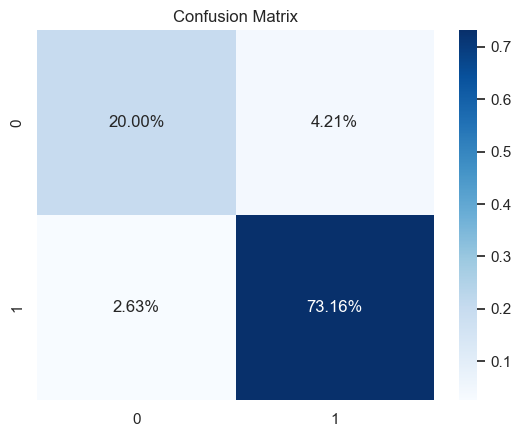

In [29]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
sns.heatmap(confusion_mtx/np.sum(confusion_mtx), annot=True, 
            fmt='.2%', cmap='Blues')

In [30]:
from sklearn.metrics import classification_report

In [31]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85        46
           1       0.95      0.97      0.96       144

    accuracy                           0.93       190
   macro avg       0.91      0.90      0.90       190
weighted avg       0.93      0.93      0.93       190



In [32]:
#saving the trained cnn model
model.save("fake-image-detection.h5")

In [33]:
from tensorflow.keras.models import load_model
from PIL import ImageChops, ImageEnhance
import numpy as np
import os

In [99]:
#load the trained model
model = load_model("fake-image-detection.h5")

In [84]:
def convert_to_ela_image(path, quality=90):
    original_image = Image.open(path).convert('RGB')
    resaved_image_path = 'resaved_image.jpg'
    original_image.save(resaved_image_path, 'JPEG', quality=quality)
    resaved_image = Image.open(resaved_image_path)
    ela_image = ImageChops.difference(original_image, resaved_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    return ela_image

In [85]:
def prepare_image(image_path):
    ela_image = convert_to_ela_image(image_path)
    ela_image = ela_image.resize((128, 128))
    ela_image = np.array(ela_image) / 255.0
    ela_image = ela_image.reshape((1, 128, 128, 3))
    return ela_image

In [105]:
def predict_image(image_path, model):
    prepared_image = prepare_image(image_path)
    prediction = model.predict(prepared_image)
    return 'Real' if np.argmax(prediction) == 1 else 'Fake'

In [106]:
def predict_on_folder(folder_path, model):
    results = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder_path, filename)
            result = predict_image(image_path, model)
            results[filename] = result
    return results

In [107]:

# Define the folder path
folder_path = 'deepfake_dataset/data/test/real'

# Predict on the folder
results = predict_on_folder(folder_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

In [108]:
# Print results
for filename, result in results.items():
    print(f"{filename}: {result}")

6401_0.jpg: Real
6402_0.jpg: Real
6403_0.jpg: Real
6404_0.jpg: Real
6405_0.jpg: Real
6406_0.jpg: Real
6407_0.jpg: Real
6408_0.jpg: Real
6409_0.jpg: Real
6410_0.jpg: Real
6411_0.jpg: Real
6412_0.jpg: Real
6413_0.jpg: Real
6414_0.jpg: Real
6415_0.jpg: Real
6416_0.jpg: Real
6417_0.jpg: Real
6418_0.jpg: Real
6419_0.jpg: Real
6420_0.jpg: Real
6421_0.jpg: Real
6422_0.jpg: Real
6423_0.jpg: Real
6424_0.jpg: Real
6425_0.jpg: Real
6426_0.jpg: Real
6427_0.jpg: Real
6428_0.jpg: Real
6429_0.jpg: Real
6430_0.jpg: Real
6431_0.jpg: Real
6432_0.jpg: Real
6433_0.jpg: Real
6434_0.jpg: Real
6435_0.jpg: Real
6436_0.jpg: Real
6437_0.jpg: Real
6438_0.jpg: Real
6439_0.jpg: Real
6440_0.jpg: Real
6441_0.jpg: Real
6442_0.jpg: Real
6443_0.jpg: Real
6444_0.jpg: Real
6445_0.jpg: Real
6446_0.jpg: Real
6447_0.jpg: Real
6448_0.jpg: Real
6449_0.jpg: Real
6450_0.jpg: Real
6451_0.jpg: Real
6452_0.jpg: Real
6453_0.jpg: Real
6454_0.jpg: Real
6455_0.jpg: Real
6456_0.jpg: Real
6457_0.jpg: Real
6458_0.jpg: Real
6459_0.jpg: Re

In [110]:
# Define the folder path
folder_path = 'deepfake_dataset/data/test/fake'

# Predict on the folder
results = predict_on_folder(folder_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

In [111]:
# Print results
for filename, result in results.items():
    print(f"{filename}: {result}")

1601_0.jpg: Fake
1602_0.jpg: Fake
1603_0.jpg: Fake
1604_0.jpg: Fake
1605_0.jpg: Fake
1606_0.jpg: Fake
1607_0.jpg: Fake
1608_0.jpg: Fake
1609_0.jpg: Fake
1610_0.jpg: Fake
1611_0.jpg: Fake
1612_0.jpg: Fake
1613_1.jpg: Fake
1614_0.jpg: Fake
1615_0.jpg: Fake
1616_0.jpg: Fake
1617_0.jpg: Fake
1618_0.jpg: Fake
1619_0.jpg: Fake
1620_0.jpg: Fake
1621_0.jpg: Fake
1622_0.jpg: Fake
1623_0.jpg: Fake
1624_0.jpg: Fake
1625_0.jpg: Fake
1626_0.jpg: Fake
1627_0.jpg: Fake
1628_0.jpg: Fake
1629_0.jpg: Fake
1630_0.jpg: Fake
1631_0.jpg: Fake
1632_0.jpg: Fake
1633_0.jpg: Fake
1634_0.jpg: Fake
1635_0.jpg: Fake
1636_0.jpg: Fake
1637_0.jpg: Fake
1639_0.jpg: Fake
1640_0.jpg: Fake
1641_0.jpg: Fake
1642_0.jpg: Fake
1643_0.jpg: Fake
1645_0.jpg: Fake
1646_0.jpg: Fake
1647_0.jpg: Fake
1648_0.jpg: Fake
1649_0.jpg: Fake
1650_0.jpg: Fake
1651_0.jpg: Fake
1652_0.jpg: Fake
1653_0.jpg: Fake
1654_0.jpg: Fake
1655_0.jpg: Fake
1656_0.jpg: Fake
1657_0.jpg: Fake
1658_0.jpg: Fake
1659_0.jpg: Fake
1660_0.jpg: Fake
1661_0.jpg: Fa

In [112]:
# Predict on a new image
image_path = 'deepfake_dataset/data/test/fake/1609_0.jpg'
result = predict_image(image_path, model)
print(f'The image is predicted to be: {result}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
The image is predicted to be: Fake


In [113]:
image_path = 'deepfake_dataset/data/test/real/6454_0.jpg'
result = predict_image(image_path, model)
print(f'The image is predicted to be: {result}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
The image is predicted to be: Real
